In [1]:
import sys
sys.path.append('../scripts')

from featherflight import FeatherFlight
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
tqdm.pandas()

In [2]:
ff = FeatherFlight()
ff.calculate_distances_routes()

Exploration for future trouble shooting

# 1. Don't use IATA code for airport

The information for the various airports has to be accessed with the Airport ID.

In [3]:
airports = pd.read_csv('downloads/airports.csv')
print(airports.shape)
# Compute the number of missing values in each column
airports.apply(lambda x: x==r"\N").sum()

(7698, 15)


index                       0
Airport ID                  0
Name                        0
City                        0
Country                     0
IATA                     1626
ICAO                        1
Latitude                    0
Longitude                   0
Altitude                    0
Timezone                  353
DST                       353
Tz database time zone    1021
Type                        0
Source                      0
dtype: int64

In [4]:
airports.isna().sum()

index                     0
Airport ID                0
Name                      0
City                     49
Country                   0
IATA                      0
ICAO                      0
Latitude                  0
Longitude                 0
Altitude                  0
Timezone                  0
DST                       0
Tz database time zone     0
Type                      0
Source                    0
dtype: int64

In [5]:
airports.isnull().sum()

index                     0
Airport ID                0
Name                      0
City                     49
Country                   0
IATA                      0
ICAO                      0
Latitude                  0
Longitude                 0
Altitude                  0
Timezone                  0
DST                       0
Tz database time zone     0
Type                      0
Source                    0
dtype: int64

# 2. Missing information in the routes

## 2.1. IATA codes

In [6]:
routes = pd.read_csv('downloads/routes.csv')
nroutes = routes.shape[0]

routes["Source airport ID"] = routes["Source airport ID"].astype(str)
routes["Destination airport ID"] = routes["Destination airport ID"].astype(str)
airports["Airport ID"] = airports["Airport ID"].astype(str)

IATA_missing = np.logical_or(
    np.logical_or(
        routes["Source airport"] == r"\N",
        routes["Destination airport"] == r"\N"),
    np.logical_or(
        ~routes["Source airport"].isin(airports["IATA"]),
        ~routes["Destination airport"].isin(airports["IATA"]))
)

print(
    f"We have {sum(IATA_missing)} problematic routes" +
    f" out of {nroutes} ({sum(IATA_missing)/nroutes:.2%})")

We have 729 problematic routes out of 67663 (1.08%)


## 2.2. Airline ID

In [7]:
problematic_routes = np.logical_or(
    np.logical_or(
        routes["Source airport ID"] == r"\N",
        routes["Destination airport ID"] == r"\N"),
    np.logical_or(
        ~routes["Source airport ID"].isin(airports["Airport ID"]),
        ~routes["Destination airport ID"].isin(airports["Airport ID"]))
)
print(
    f"We have {sum(problematic_routes)} problematic routes" +
    f" out of {nroutes} ({sum(problematic_routes)/nroutes:.2%})")

routes_ts = routes[problematic_routes]

We have 892 problematic routes out of 67663 (1.32%)


In [8]:
correction = np.logical_and(
    routes_ts["Source airport"].isin(airports["IATA"]),
    routes_ts["Destination airport"].isin(airports["IATA"]))

print(
    f"We can find a matching IATA for {sum(correction)}"+
    f" of these problematic routes ({sum(correction)/sum(problematic_routes):.2%})")

We can find a matching IATA for 321 of these problematic routes (35.99%)


In [9]:
# routes = routes[~problematic_routes]

# airports_gdf = gpd.GeoDataFrame(
#     airports,
#     geometry=[
#         Point(xy) for xy in zip(airports.Longitude, airports.Latitude)
#     ],
#     crs="EPSG:4326",
# )
# airports_gdf = airports_gdf.to_crs("EPSG:3395")

airports["Point"] = [(x, y) for x, y in zip(airports.Latitude, airports.Longitude)]

if "Point_source" not in routes.columns:
    routes = pd.merge(
        routes,
        airports[["Airport ID", "Point"]],
        how="left",
        left_on="Source airport ID",
        right_on="Airport ID",
    ).rename(columns={"Point": "Point_source"}).drop("Airport ID", axis=1)

if "Point_destination" not in routes.columns:
    routes = pd.merge(
        routes,
        airports[["Airport ID", "Point"]],
        how="left",
        left_on="Destination airport ID",
        right_on="Airport ID",
    ).rename(columns={"Point": "Point_destination"}).drop("Airport ID", axis=1)


routes["Distance"] = routes.progress_apply(
    lambda row: geodesic(row.Point_source, row.Point_destination).kilometers
    if pd.notnull(row.Point_source) and pd.notnull(row.Point_destination)
    else np.nan,
    axis=1
)


100%|██████████| 67663/67663 [00:15<00:00, 4396.72it/s]


In [25]:
print(
    f"We are missing the distances for {routes.Distance.isna().sum()} routes" + 
    " where the airports could not be matched.")

We are missing the distances for 892 routes where the airports could not be matched.


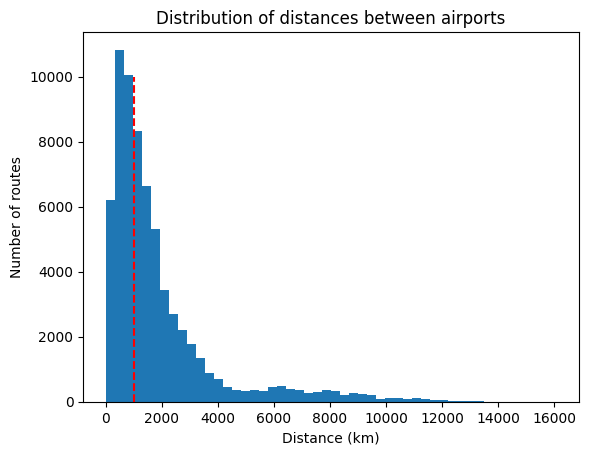

In [11]:
import matplotlib.pyplot as plt

routes["Short haul"] = routes["Distance"] < 1000
plt.hist(routes["Distance"], bins=50)
plt.vlines(1000, 0, 10000, color="red", linestyle="--")
plt.xlabel("Distance (km)")
plt.ylabel("Number of routes")
plt.title("Distribution of distances between airports")
plt.show()

In [12]:
airports_gdf = gpd.GeoDataFrame(
    airports,
    geometry=[
        Point(xy) for xy in zip(airports.Longitude, airports.Latitude)
    ],
    crs="EPSG:4326",
)
airports_gdf = airports_gdf.to_crs(epsg=3395)


In [13]:
routes = routes
# merge routes with airports' geometries to get the coordinates
source_geo = gpd.GeoDataFrame(
    pd.merge(
        routes,
        airports_gdf[["Airport ID", "geometry"]],
        how="left",
        left_on="Source airport ID",
        right_on="Airport ID",
    ).drop("Airport ID", axis=1),
    geometry="geometry",
    crs="EPSG:3395"
)
destination_geo = gpd.GeoDataFrame(
    pd.merge(
        routes,
        airports_gdf[["Airport ID", "geometry"]],
        how="left",
        left_on="Destination airport ID",
        right_on="Airport ID",
    ).drop("Airport ID", axis=1),
    geometry="geometry",
    crs="EPSG:3395"
)

routes["distance_km"] = source_geo.geometry.distance(destination_geo.geometry) / 1000


# # handling the error of not recognition of routes as non geospatial dataframe, by setting a geometry column
# routes_with_geo = gpd.GeoDataFrame(
#     routes_with_geo, geometry="geometry_source", crs="EPSG:3395"
# )

# # distances calculation
# routes_with_geo["distance_km"] = routes_with_geo.apply(
#     lambda row: row["geometry_source"].distance(
#         row["geometry_dest"]) / 1000
#     if pd.notnull(row["geometry_source"]) and pd.notnull(row["geometry_dest"])
#     else None,
#     axis=1,
# )

In [16]:
ff = FeatherFlight()
ff.calculate_distances_geopandas()

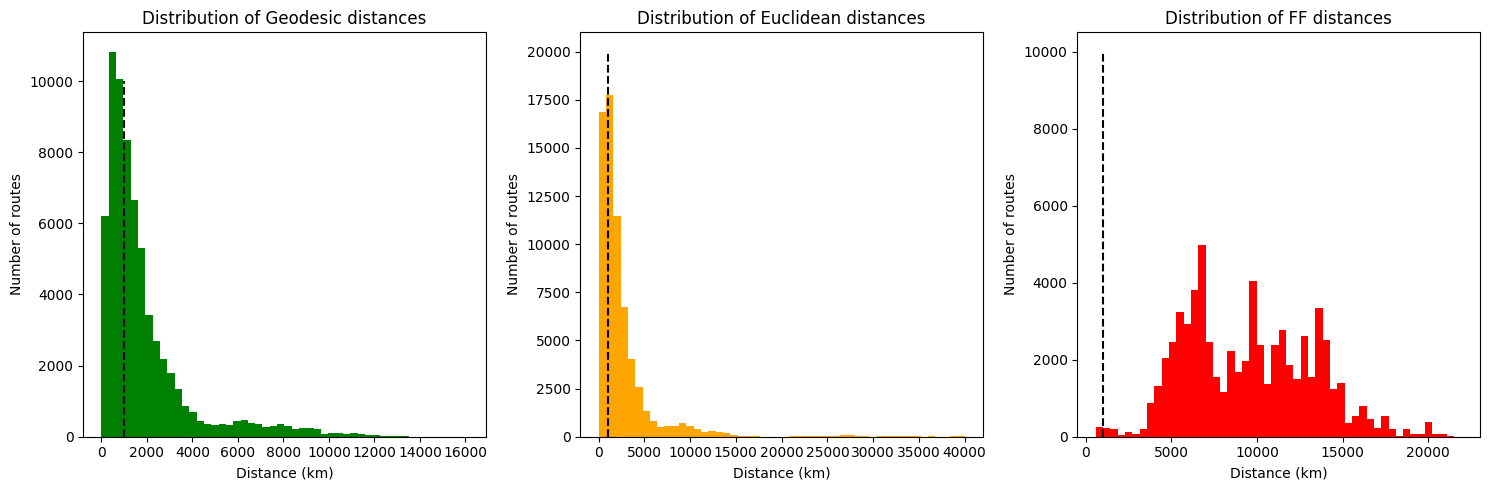

In [21]:
# Add the Distance and distance_km to a single plot

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(routes["Distance"], bins=50,color="green")
ax[0].vlines(1000, 0, 10000, color="black", linestyle="--")
ax[0].set_xlabel("Distance (km)")
ax[0].set_ylabel("Number of routes")
ax[0].set_title("Distribution of Geodesic distances")

ax[1].hist(routes["distance_km"], bins=50, color="orange")
ax[1].vlines(1000, 0, 20000, color="black", linestyle="--")
ax[1].set_xlabel("Distance (km)")
ax[1].set_ylabel("Number of routes")
ax[1].set_title("Distribution of Euclidean distances")

ax[2].hist(ff.routes["distance_km"], bins=50, color="red")
ax[2].vlines(1000, 0, 10000, color="black", linestyle="--")
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Number of routes")
ax[2].set_title("Distribution of FF distances")

plt.tight_layout()
plt.show()

